In [19]:
%load_ext autoreload
%autoreload 2
from sklearn.datasets import make_circles

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
n_samples = 1000
X, y = make_circles(n_samples=n_samples,
                    noise=0.03,
                    random_state=42)

In [21]:
len(X), len(y)

(1000, 1000)

In [22]:
print(f"first 5 samples of X: {X[:5]}")
print(f"first 5 samples of y: {y[:5]}")

first 5 samples of X: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
first 5 samples of y: [1 1 1 1 0]


In [23]:
import pandas as pd

circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


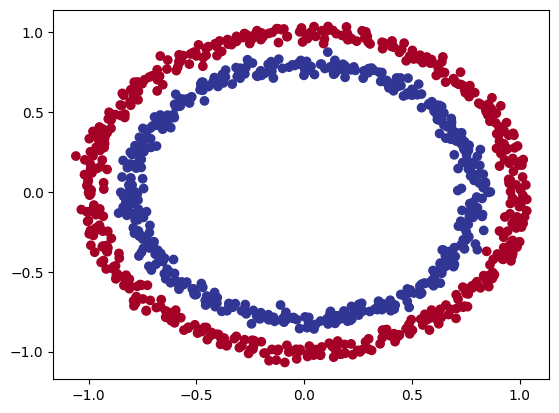

In [24]:
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [25]:
X.shape

(1000, 2)

In [26]:
X_sample = X[0]
y_sample = y[0]

print(f"values for one sample of x: {X_sample} and the same for y: {y_sample}")
print(f"shapes for one sample of x: {X_sample.shape} and the same for y: {y_sample.shape}")

values for one sample of x: [0.75424625 0.23148074] and the same for y: 1
shapes for one sample of x: (2,) and the same for y: ()


In [27]:
import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [28]:
from sklearn.model_selection import train_test_split

data_train, data_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Build

In [29]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [30]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

        # self.two_linear_layers = nn.Sequential(
        #     nn.Linear(in_features=2, out_features=5),
        #     nn.Linear(in_features=5, out_features=1)
        # )

    def forward(self, x):
        return self.layer_2(self.layer_1(x))
        # return self.two_linear_layers(x)


model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [31]:
next(model_0.parameters()).device

device(type='cuda', index=0)

 # other way

In [32]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [33]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.3749, -0.5871],
                      [ 0.0861,  0.6526],
                      [ 0.3012,  0.0491],
                      [ 0.2268, -0.1413],
                      [-0.1934, -0.6649]], device='cuda:0')),
             ('0.bias',
              tensor([-0.0233,  0.6481, -0.3706, -0.4464, -0.3968], device='cuda:0')),
             ('1.weight',
              tensor([[-0.3381,  0.1857,  0.2426, -0.3013, -0.0119]], device='cuda:0')),
             ('1.bias', tensor([-0.0543], device='cuda:0'))])

In [34]:
with torch.inference_mode():
    untrained_preds = model_0(data_test.to(device))
    print(len(untrained_preds), untrained_preds.shape)
    print(len(data_test), data_test.shape)
    print(untrained_preds[:10])

200 torch.Size([200, 1])
200 torch.Size([200, 2])
tensor([[ 0.4231],
        [ 0.4885],
        [ 0.0759],
        [ 0.5221],
        [-0.2027],
        [-0.1605],
        [ 0.2446],
        [ 0.0919],
        [ 0.0882],
        [ 0.4898]], device='cuda:0')


In [35]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [60]:
# accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [40]:
y_logits = model_0(data_test.to(device))[:5]
y_logits

tensor([[ 0.4231],
        [ 0.4885],
        [ 0.0759],
        [ 0.5221],
        [-0.2027]], device='cuda:0', grad_fn=<SliceBackward0>)

In [41]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [42]:
y_pred_prods = torch.sigmoid(y_logits)
y_pred_prods

tensor([[0.6042],
        [0.6198],
        [0.5190],
        [0.6276],
        [0.4495]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [43]:
torch.round(y_pred_prods)

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [0.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [45]:
y_pred = torch.round(y_pred_prods)

y_pred_labels = torch.round(torch.sigmoid(model_0(data_test.to(device))[:5]))
print(torch.eq(y_pred.squeeze(), y_pred_labels.squeeze()))


tensor([True, True, True, True, True], device='cuda:0')


In [56]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

data_train, y_train = data_train.to(device), y_train.to(device)
data_test, y_test = data_test.to(device), y_test.to(device)

In [62]:
for epoch in range(epochs):
    model_0.train()

    y_logits = model_0(data_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)  # BCE with sigmoid need raw logits
    # loss = loss_fn(y_pred, y_train) # BCE without sigmoid need probabilities
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(data_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % 10 == 0:
        print(
            f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70060, Acc: 51.50% | Test Loss: 0.70901, Test acc: 50.50%
Epoch: 10 | Loss: 0.69750, Acc: 51.25% | Test Loss: 0.70440, Test acc: 48.00%
Epoch: 20 | Loss: 0.69612, Acc: 51.00% | Test Loss: 0.70199, Test acc: 47.00%
Epoch: 30 | Loss: 0.69537, Acc: 50.75% | Test Loss: 0.70051, Test acc: 48.00%
Epoch: 40 | Loss: 0.69488, Acc: 50.00% | Test Loss: 0.69947, Test acc: 48.00%
Epoch: 50 | Loss: 0.69452, Acc: 50.25% | Test Loss: 0.69869, Test acc: 50.00%
Epoch: 60 | Loss: 0.69425, Acc: 50.12% | Test Loss: 0.69806, Test acc: 50.50%
Epoch: 70 | Loss: 0.69403, Acc: 50.12% | Test Loss: 0.69755, Test acc: 50.50%
Epoch: 80 | Loss: 0.69385, Acc: 50.12% | Test Loss: 0.69713, Test acc: 50.00%
Epoch: 90 | Loss: 0.69371, Acc: 50.12% | Test Loss: 0.69677, Test acc: 50.00%


In [63]:
import numpy as np


def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

In [65]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Download helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)
from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


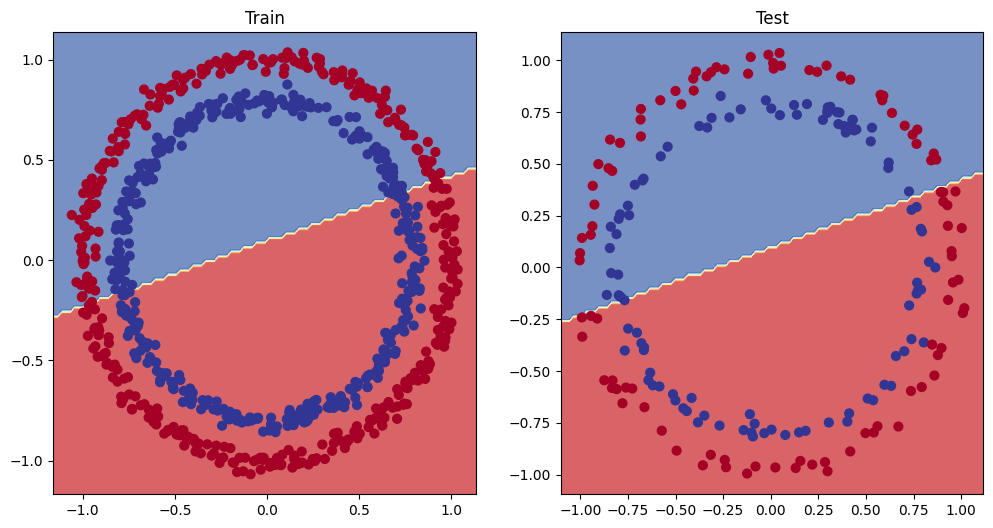

In [80]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, data_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, data_test, y_test)

In [67]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        return self.layer_3(self.layer_2(self.layer_1(x)))


model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [68]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)


In [77]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

data_train, y_train = data_train.to(device), y_train.to(device)
data_test, y_test = data_test.to(device), y_test.to(device),

for epoch in range(epochs):
    model_1.train()

    y_logits = model_1(data_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(data_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % 100 == 0:
        print(
            f"Epochs:{epoch} | Loss:{loss:.5f}, accuracy:{int(acc)}% | testLoss:{test_loss:.5f}, testaccuracy:{int(test_acc)}%")

Epochs:0 | Loss:0.69298, accuracy:51% | testLoss:0.69468, testaccuracy:46%
Epochs:100 | Loss:0.69298, accuracy:51% | testLoss:0.69468, testaccuracy:46%
Epochs:200 | Loss:0.69298, accuracy:51% | testLoss:0.69468, testaccuracy:46%
Epochs:300 | Loss:0.69298, accuracy:51% | testLoss:0.69468, testaccuracy:46%
Epochs:400 | Loss:0.69298, accuracy:51% | testLoss:0.69468, testaccuracy:46%
Epochs:500 | Loss:0.69298, accuracy:51% | testLoss:0.69468, testaccuracy:46%
Epochs:600 | Loss:0.69298, accuracy:51% | testLoss:0.69468, testaccuracy:46%
Epochs:700 | Loss:0.69298, accuracy:51% | testLoss:0.69468, testaccuracy:46%
Epochs:800 | Loss:0.69298, accuracy:51% | testLoss:0.69468, testaccuracy:46%
Epochs:900 | Loss:0.69298, accuracy:51% | testLoss:0.69468, testaccuracy:46%


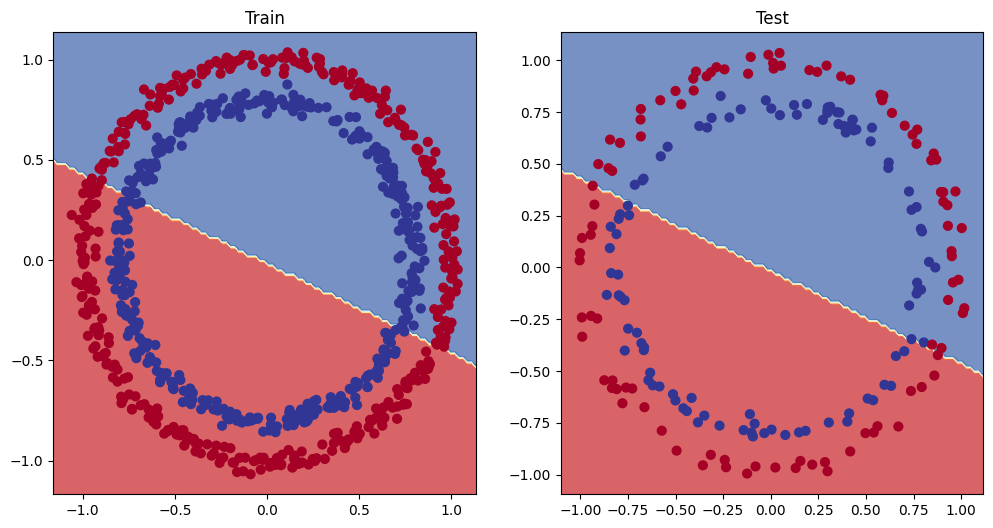

In [82]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, data_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, data_test, y_test)

# circles final

In [129]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

data = make_circles(n_samples=n_samples, noise=0, random_state=42)

In [130]:
import torch
from sklearn.model_selection import train_test_split

data_x = torch.from_numpy(data[0]).type(torch.float)
data_y = torch.from_numpy(data[1]).type(torch.float)

data_train, data_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.2, random_state=42)

In [137]:
from torch import nn


class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=32)
        self.layer_2 = nn.Linear(in_features=32, out_features=32)
        self.layer_3 = nn.Linear(in_features=32, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x: torch.tensor) -> torch.tensor:
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))


model_2 = CircleModelV2()
model_2 = model_2.to(device)
model_2

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=32, bias=True)
  (layer_2): Linear(in_features=32, out_features=32, bias=True)
  (layer_3): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
)

In [138]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

In [139]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 1000

data_train, y_train = data_train.to(device), y_train.to(device)
data_test, y_test = data_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_2.train()

    y_logits = model_2(data_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_2.eval()
    with torch.inference_mode():
        test_logits = model_2(data_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % 100 == 0:
        print(
            f"Epoch:{epoch} | Loss:{loss:.5f}, Accuracy:{acc:.2f} | Test_Loss:{test_loss:.5f}, Test_Accuracy:{test_acc:.2f}")

Epoch:0 | Loss:0.69472, Accuracy:46.88 | Test_Loss:0.69454, Test_Accuracy:47.00
Epoch:100 | Loss:0.68962, Accuracy:56.50 | Test_Loss:0.68924, Test_Accuracy:59.00
Epoch:200 | Loss:0.68395, Accuracy:65.62 | Test_Loss:0.68368, Test_Accuracy:64.00
Epoch:300 | Loss:0.67462, Accuracy:73.75 | Test_Loss:0.67482, Test_Accuracy:77.50
Epoch:400 | Loss:0.65665, Accuracy:82.38 | Test_Loss:0.65749, Test_Accuracy:82.00
Epoch:500 | Loss:0.61766, Accuracy:98.50 | Test_Loss:0.61985, Test_Accuracy:99.00
Epoch:600 | Loss:0.53422, Accuracy:100.00 | Test_Loss:0.53713, Test_Accuracy:100.00
Epoch:700 | Loss:0.37636, Accuracy:100.00 | Test_Loss:0.38000, Test_Accuracy:100.00
Epoch:800 | Loss:0.20061, Accuracy:100.00 | Test_Loss:0.20466, Test_Accuracy:100.00
Epoch:900 | Loss:0.64508, Accuracy:50.38 | Test_Loss:0.53943, Test_Accuracy:63.50


In [140]:
next(model_2.parameters()).device

device(type='cuda', index=0)

In [141]:
model_2.eval()
with torch.inference_mode():
    y_pred = torch.round(torch.sigmoid(model_2(data_test)))

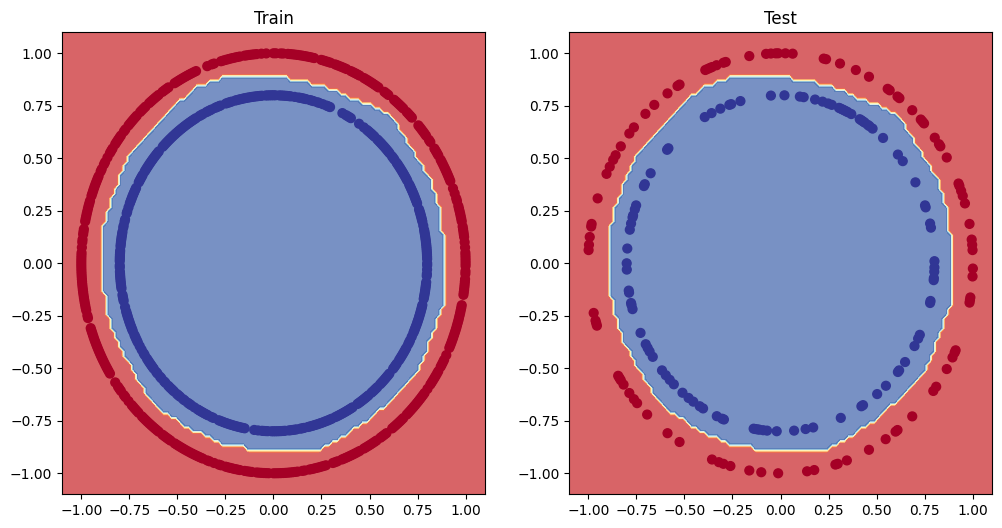

In [142]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_2, data_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2, data_test, y_test)

# relu

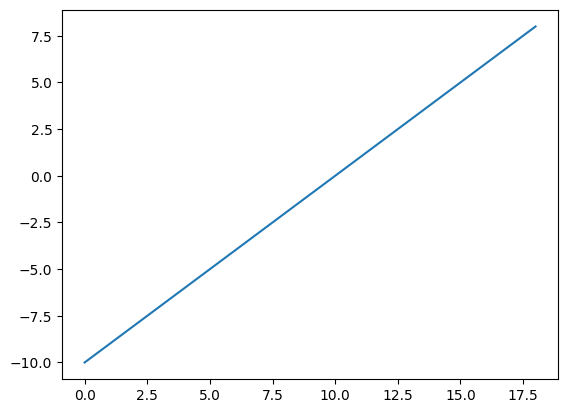

In [144]:
a = torch.arange(-10, 9, 1, dtype=torch.float)
plt.plot(a);

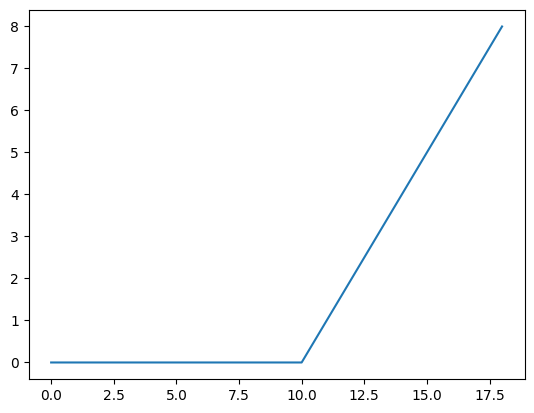

In [146]:
plt.plot(torch.relu(a));

In [147]:
def relu(x):
    return torch.maximum(torch.tensor(0), x)


relu(a)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8.])

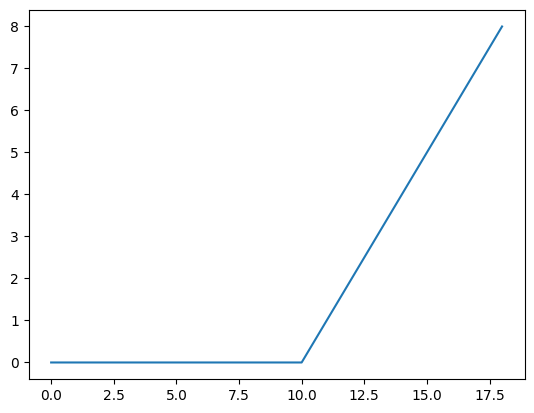

In [149]:
plt.plot(relu(a));

# Sigmoid

In [154]:
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))


sigmoid(a)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01])

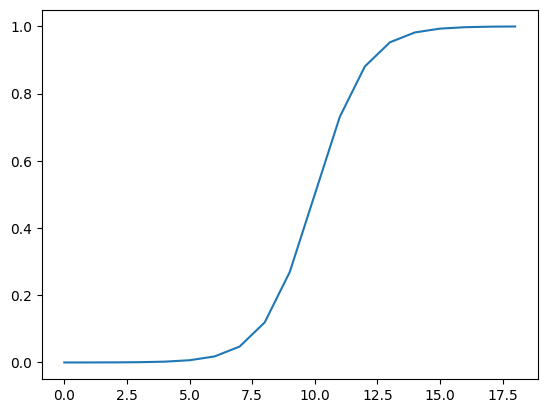

In [155]:
plt.plot(sigmoid(a));

# multy classification

Epoch:0 | Loss:1.58551, Accuracy:0.38 | TestLoss:1.45682, TestAccuracy:0.00
Epoch:10 | Loss:0.85042, Accuracy:75.12 | TestLoss:0.80997, TestAccuracy:71.00
Epoch:20 | Loss:0.47608, Accuracy:93.50 | TestLoss:0.45609, TestAccuracy:99.50
Epoch:30 | Loss:0.26324, Accuracy:98.38 | TestLoss:0.24940, TestAccuracy:99.50
Epoch:40 | Loss:0.12610, Accuracy:99.38 | TestLoss:0.11569, TestAccuracy:100.00
Epoch:50 | Loss:0.07759, Accuracy:99.50 | TestLoss:0.06903, TestAccuracy:99.50
Epoch:60 | Loss:0.05784, Accuracy:99.50 | TestLoss:0.04945, TestAccuracy:99.50
Epoch:70 | Loss:0.04767, Accuracy:99.50 | TestLoss:0.03913, TestAccuracy:99.50
Epoch:80 | Loss:0.04159, Accuracy:99.50 | TestLoss:0.03289, TestAccuracy:99.50
Epoch:90 | Loss:0.03761, Accuracy:99.50 | TestLoss:0.02872, TestAccuracy:99.50


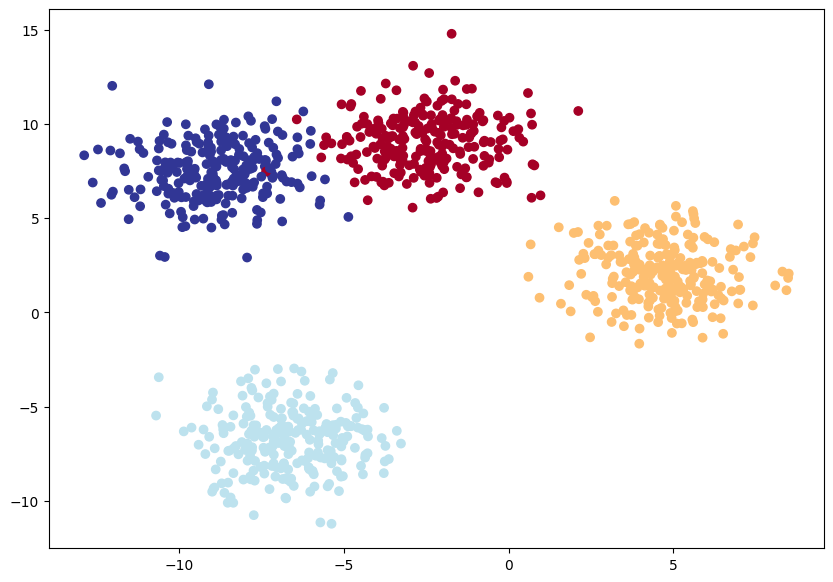

In [238]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

n_classes = 4
n_features = 2
seed = 42

X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=n_features,
                            centers=n_classes,
                            cluster_std=1.5,
                            random_state=seed)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.long)

data_train, data_test, y_train, y_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=seed)

plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)


class BlobModel(nn.Module):
    def __init__(self, input_layer, hidden_layer, output_layer):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features=input_layer, out_features=hidden_layer),
            nn.ReLU(),
            nn.Linear(in_features=hidden_layer, out_features=hidden_layer),
            nn.ReLU(),
            nn.Linear(in_features=hidden_layer, out_features=output_layer)
        )

    def forward(self, x):
        return self.layers(x)


model_3 = BlobModel(2, 8, 4)
model_3 = model_3.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

data_train, data_test, y_train, y_test = data_train.to(device), data_test.to(device), y_train.to(device), y_test.to(device)

epochs = 100
for epoch in range(epochs):
    model_3.train()
    y_logit = model_3(data_train)
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    loss = criterion(y_logit, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model_3.eval()
    with torch.inference_mode():
        test_logit = model_3(data_test)
        test_pred = torch.softmax(test_logit,dim=1).argmax(dim=1)
        test_loss = criterion(test_logit, y_test)
        test_acc = accuracy_fn(y_test, test_pred)
        
    if epoch % 10 == 0:
        print(f"Epoch:{epoch} | Loss:{loss:.5f}, Accuracy:{acc:.2f} | TestLoss:{test_loss:.5f}, TestAccuracy:{test_acc:.2f}")

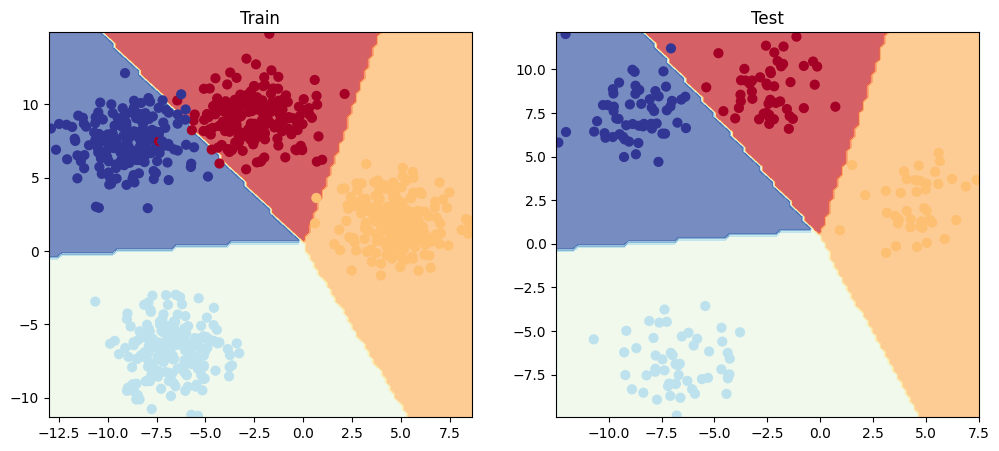

In [225]:
model_3.eval()
model_3 = model_3.to(device)
with torch.inference_mode():
    test_logit = model_3(data_test.to(device))
    test_pred = torch.softmax(test_logit,dim=1).argmax(dim=1)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3, data_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3, data_test, y_test)


In [231]:
from torchmetrics import Accuracy
accuracy = Accuracy(task="multiclass", num_classes=4).to(device)
accuracy(test_pred, y_test)

tensor(0.9950, device='cuda:0')

In [235]:
from sklearn.metrics import classification_report
c = classification_report(y_true=y_test.cpu(), y_pred=test_pred.cpu())

In [237]:
print(c)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        49
           1       1.00      1.00      1.00        41
           2       1.00      1.00      1.00        53
           3       1.00      0.98      0.99        57

    accuracy                           0.99       200
   macro avg       0.99      1.00      1.00       200
weighted avg       1.00      0.99      1.00       200
